### Import libraries

In [1]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging
import platform

from datetime import datetime

import random
random.seed(seed)

In [2]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras import mixed_precision
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [3]:
# Import other libraries
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
from PIL import Image
import imagehash
from sklearn.model_selection import KFold
import zipfile

In [4]:
# Setup Mixed Precision

# Detect TPU
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
except ValueError:
  tpu = None

if tpu:
  policyConfig = 'mixed_bfloat16'
else: 
  policyConfig = 'mixed_float16'

#policy = tf.keras.mixed_precision.Policy(policyConfig)
#tf.keras.mixed_precision.set_global_policy(policy)

### Load the dataset

In [5]:
# Load the data from the file
file_path = 'cleaned_data.npz'
loaded_data = np.load(file_path, allow_pickle=True)

# Put data into proper arrays
data = loaded_data['data']
labels = loaded_data['labels']

### Prepare and augment data

In [6]:
healthy = []
unhealthy = []

# Iterate through the images to separate them into the proper set
for i, image in enumerate(data):
    if labels[i] == 'unhealthy':
        unhealthy.append(image)
    else:
        healthy.append(image)

print(len(healthy))
print(len(unhealthy))

3060
1790


In [7]:
flip = tf.keras.Sequential([
  tfkl.RandomFlip("vertical"),
])

rotation = tf.keras.Sequential([
  tfkl.RandomRotation(0.2),
])

zoom = tf.keras.Sequential([
  tfkl.RandomZoom(0.2),
])

translation = tf.keras.Sequential([
  tfkl.RandomTranslation(0.2,0.2),
])

contrast = tf.keras.Sequential([
  tfkl.RandomContrast(0.75),
])

def apply_random_brightness(image):
    # Convert to TensorFlow tensor
    image_tensor = tf.convert_to_tensor(image, dtype=tf.float32)

    # Apply random brightness
    brightness_factor = tf.random.uniform([], -0.5, 0.5)  # Adjust the range as needed
    brightened_image = tf.image.adjust_brightness(image_tensor, brightness_factor)

    # Convert back to NumPy array
    brightened_image_np = brightened_image.numpy()

    return brightened_image_np

####

In [8]:
healthy = np.array(healthy)
N = 900
N2 = int(N/3)

# Preprocess 'healthy' set
preprocessed_healthy_flip = healthy[:N2]
preprocessed_healthy_flip = flip(preprocessed_healthy_flip)

preprocessed_healthy_rotate = healthy[:N2]
preprocessed_healthy_rotate = rotation(preprocessed_healthy_rotate)

preprocessed_healthy_zoom = healthy[:N2]
preprocessed_healthy_zoom = zoom(preprocessed_healthy_zoom)

preprocessed_healthy_translation = healthy[:N2]
preprocessed_healthy_translation = translation(preprocessed_healthy_translation)

preprocessed_healthy_constrast = healthy[:N2]
preprocessed_healthy_constrast = contrast(preprocessed_healthy_constrast)

preprocessed_healthy = np.concatenate([
    preprocessed_healthy_rotate, 
    preprocessed_healthy_flip,
    preprocessed_healthy_zoom,
    preprocessed_healthy_translation,
    preprocessed_healthy_constrast
], axis=0)


In [9]:
unhealthy = np.array(unhealthy)
M = 1500
M2 = int(M/3)

# Preprocess 'healthy' set
preprocessed_unhealthy_flip = unhealthy[: M2]
preprocessed_unhealthy_flip = flip(preprocessed_unhealthy_flip)

preprocessed_unhealthy_rotate = unhealthy[: M2]
preprocessed_unhealthy_rotate = rotation(preprocessed_unhealthy_rotate)

preprocessed_unhealthy_zoom = unhealthy[: M2]
preprocessed_unhealthy_zoom = zoom(preprocessed_unhealthy_zoom)

preprocessed_unhealthy_translation = unhealthy[: M2]
preprocessed_unhealthy_translation = translation(preprocessed_unhealthy_translation)

preprocessed_unhealthy_constrast = unhealthy[: M2]
preprocessed_unhealthy_constrast = contrast(preprocessed_unhealthy_constrast)

preprocessed_unhealthy = np.concatenate([
    preprocessed_unhealthy_rotate, 
    preprocessed_unhealthy_flip,
    preprocessed_unhealthy_zoom,
    preprocessed_unhealthy_translation,
    preprocessed_unhealthy_constrast
], axis=0)

In [10]:
# Concatenate the preprocessed sets
preprocessed_data = np.concatenate([preprocessed_healthy, preprocessed_unhealthy], axis=0)

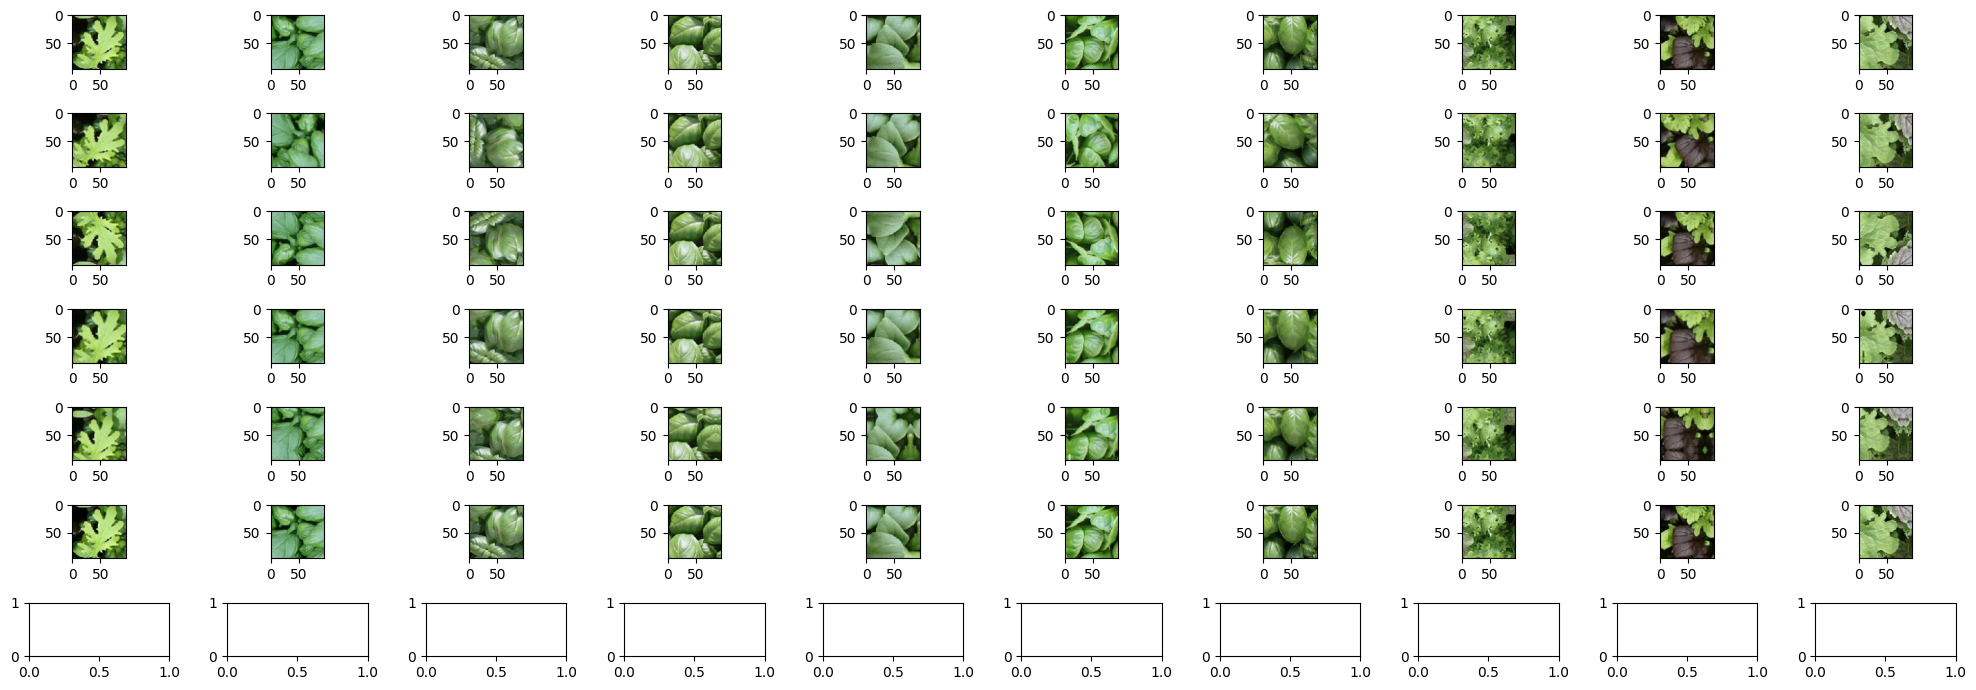

In [11]:
# Plot
healthy_np = np.array(healthy)
preprocessed_healthy_rotate_np = np.array(preprocessed_healthy_rotate)
preprocessed_healthy_flip_np = np.array(preprocessed_healthy_flip)
preprocessed_healthy_zoom_np = np.array(preprocessed_healthy_zoom)
preprocessed_healthy_translation_np = np.array(preprocessed_healthy_translation)
preprocessed_healthy_contrast_np = np.array(preprocessed_healthy_constrast)

num_img = 10

fig, axes = plt.subplots(7, num_img, figsize=(20, 7))
for i in range(num_img):
    ax = axes[0, i % num_img]
    ax.imshow(healthy_np[i].astype(np.uint8), cmap='gray')
    ax = axes[1, i % num_img]
    ax.imshow(preprocessed_healthy_rotate_np[i].astype(np.uint8), cmap='gray')
    ax = axes[2, i % num_img]
    ax.imshow(preprocessed_healthy_flip_np[i].astype(np.uint8), cmap='gray')
    ax = axes[3, i % num_img]
    ax.imshow(preprocessed_healthy_zoom_np[i].astype(np.uint8), cmap='gray')
    ax = axes[4, i % num_img]
    ax.imshow(preprocessed_healthy_translation_np[i].astype(np.uint8), cmap='gray')
    ax = axes[5, i % num_img]
    ax.imshow(preprocessed_healthy_contrast_np[i].astype(np.uint8), cmap='gray')
    

plt.tight_layout()
plt.show()

In [12]:
print(len(preprocessed_healthy)) 
print(len(preprocessed_unhealthy))
print(len(preprocessed_data))

1500
2500
4000


In [13]:
augmented_data = np.concatenate([preprocessed_data, data], axis = 0)

augmented_labels_healthy = np.full((len(preprocessed_healthy),), 'healthy', dtype='object')
augmented_labels_unhealthy = np.full((len(preprocessed_unhealthy),), 'unhealthy', dtype='object')

augmented_labels = np.concatenate([augmented_labels_healthy, augmented_labels_unhealthy, labels], axis=0)

np.savez('augmented_data.npz', data=augmented_data, labels=augmented_labels)

print(len(augmented_data))
print(len(augmented_labels))

8850
8850
